# RL Training and Comparison against optimal Hedges using Black-Scholes
---
<p>
In this notebook we will train a reinforcement learning model 
<b>Proximal Policy Optimization (PPO)</b> to dynamically hedge the option at each step 
based on the provided observation space consisting of:
</p>
<ul>
<li>normalized price</li>
<li>time to maturity</li>
<li>current hedge</li>
</ul>

We will then use calculate the delta change and out hedge and finally compare 
it to the optimal hedges calculated using BSM

In [53]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import sys
import importlib
sys.path.append('../utils')
from bsm import bs_call_price, bs_delta
from env import HedgingEnv

In [54]:
def make_env(reward_type="hedge_error"):
    def _init():
        env = HedgingEnv(reward_type=reward_type)
        env = Monitor(env)
        return env
    return _init

env = DummyVecEnv([make_env(reward_type="hedge_error")])

In [55]:
model = PPO(
    "MlpPolicy", # Multi-layer perceptron (feedforward)
    env,
    learning_rate=3e-4,
    n_steps=2048, # steps before policy update
    batch_size=64,
    gamma=0.99, # 0: immedeate reward or greedy 1: Long term
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.005,
    verbose=1
)

Using cpu device


In [59]:
model.learn(total_timesteps=200_000)
model.save("ppo_hedging_model")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 251      |
|    ep_rew_mean     | -157     |
| time/              |          |
|    fps             | 5251     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 251          |
|    ep_rew_mean          | -153         |
| time/                   |              |
|    fps                  | 3691         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0067401584 |
|    clip_fraction        | 0.0984       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.279        |
|    learning_r

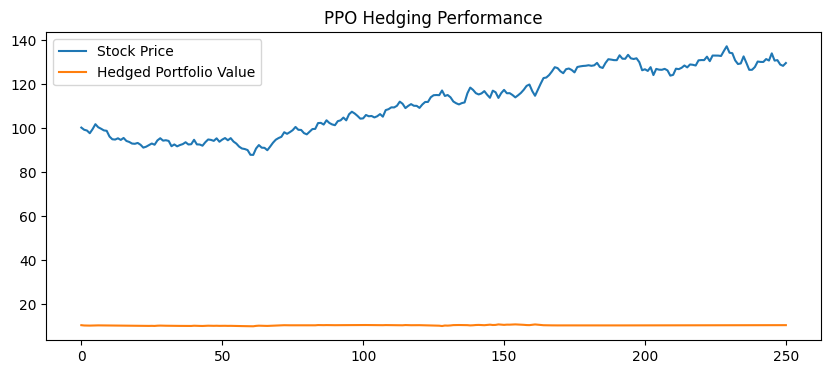

Total Reward: -111.008


In [60]:
env_test, _ = HedgingEnv(reward_type='hedge_error'), None
obs, info = env_test.reset()
done = False

prices, hedges, portfolio_vals, rewards = [], [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env_test.step(action)
    rewards.append(reward)
    prices.append(env_test.S[env_test.t])
    hedges.append(env_test.hedge)
    portfolio_vals.append(env_test.portfolio_value)

plt.figure(figsize=(10,4))
plt.plot(prices, label='Stock Price')
plt.plot(portfolio_vals, label='Hedged Portfolio Value')
plt.legend()
plt.title('PPO Hedging Performance')
plt.show()

print(f"Total Reward: {np.sum(rewards):.3f}")

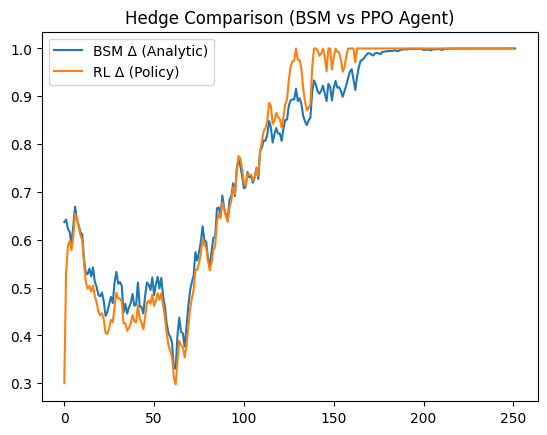

[np.float64(0.6368306511756191), np.float64(0.6422904170590122), np.float64(0.6233799765222864), np.float64(0.6163432831352618), np.float64(0.591725301676994), np.float64(0.6280612192758723), np.float64(0.6693189267537183), np.float64(0.6435451484340653), np.float64(0.6306233295839496), np.float64(0.6156818015338571), np.float64(0.6115833351232463)]
[np.float64(0.3), np.float64(0.5290831625461578), np.float64(0.5863816693425179), np.float64(0.5973999962210655), np.float64(0.578197655081749), np.float64(0.605940355360508), np.float64(0.6544701218605042), np.float64(0.6437727067619563), np.float64(0.6282241310924292), np.float64(0.6096113484352828), np.float64(0.6002590700984002)]


In [61]:
deltas_bsm = [bs_delta(S, env_test.K, env_test.mu, env_test.sigma, env_test.T - i*env_test.dt)
              for i, S in enumerate(env_test.S)]
plt.plot(deltas_bsm, label="BSM Δ (Analytic)")
plt.plot(hedges, label="RL Δ (Policy)")
plt.legend()
plt.title("Hedge Comparison (BSM vs PPO Agent)")
plt.show()
print(deltas_bsm[:11])
print(hedges[:11])

In [62]:
def eval_policy(policy=None, episodes=20, reward_type="hedge_error"):
    total_rewards = []
    for ep in range(episodes):
        env = HedgingEnv(reward_type=reward_type)
        obs, info = env.reset()
        done = False
        ep_reward = 0.0

        while not done:
            if policy is None:
                action = env.action_space.sample()
            else:
                action, _ = policy.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            ep_reward += reward
        total_rewards.append(ep_reward)
    return np.mean(total_rewards), np.std(total_rewards)

# Evaluate a random policy (baseline)
random_mean, random_std = eval_policy(policy=None)
print(f"Random policy: {random_mean:.2f} ± {random_std:.2f}")

# Evaluate the trained PPO model
ppo_mean, ppo_std = eval_policy(policy=model)
print(f"PPO-trained policy: {ppo_mean:.2f} ± {ppo_std:.2f}")

Random policy: -408.89 ± 187.04
PPO-trained policy: -113.73 ± 10.52
